# Autograd package in PyTorch

The goal of this notebook is to play around with this package to get a better understanding of how PyTorch does automatic differentiation.

In [1]:
import numpy as np
import torch
from torch.autograd import Variable, grad

### Variables

We need to wrap our tensors as variables to be able to generate the back propagation and our gradients.

Here, we create a simple scaler value $x=4$.  Even though it is nondimensional, we still need to make it a tensor.

In [2]:
x = Variable(torch.FloatTensor([4]), requires_grad=True)
print(x)
print(x.grad)

tensor([4.], requires_grad=True)
None


### Single variable polynomial

## $z = x^{3} + 2x^{2} + 8x$

We will use a lambda function for this polynominal

In [3]:
func_1 = lambda x: torch.pow(x, 3) + 2*torch.pow(x, 2) + 8*x

### First Derivative

Let's manually do the math to get the first derivative and evaluate it for $x=4$.

### $\frac{dz}{dx} = 3x^{2} + 4x + 8$

### $\frac{dz}{dx}\Bigr|_{\substack{x=4}} \quad 3*4^{2} + 4*4 + 8 = 72$

### Now let's see if PyTorch gets the same results

Generate a new tensor $z$ that is the result of our function.

We then take this result tensor and run the back propagation method.

This sets the input variable $x$ grad attribute to first derivative evaluated at $x=4$.

In [4]:
z = func_1(x)
z.backward()
print(x.grad)

tensor([72.])


## Computation Graph

Let's write our polynomial as composite functions to show how it would look as a computational graph.

We will also add the derivative with respect to the local variable $w_i$

## $z = x^{3} + 2x^{2} + 8x$

$w_1 = x \quad \rightarrow \quad \dot{w_1} = 1$

$w_2 = {w_1}^{3} \quad \rightarrow \quad \dot{w_2} = 3{w_1}^2$

$w_3 = {w_1}^{2} \quad \rightarrow \quad \dot{w_3} = 2{w_1}$

$w_4 = 2{w_3} \quad \rightarrow \quad \dot{w_4} = 2\dot{w_3} \quad$ *(chain rule)*

$w_5 = 8{w_2} \quad \rightarrow \quad \dot{w_5} = 8$

$w_6 = w_2 + w_4 + w_3 \quad \rightarrow \quad \dot{w_6} = \dot{w_2} + \dot{w_4} + \dot{w_3}$


#### Now let's find the numerical derivative for each node using $x=4$:

${w_1} = x = 4$

$\dot{w_2} = 3{w_1}^2 = 48$

$\dot{w_3} = 2{w_1} = 8$

$\dot{w_4} = 2\dot{w_3} = 16$

$\dot{w_5} = 8$

$\dot{w_6} = \dot{w_2} + \dot{w_4} + \dot{w_5} = 48 + 16 + 8 = 72$

#### This is how the gradient for the forward propagation is stored.  

PyTorch does not use calculus per se, it has a set of known derivative equations for most math functions.

During the forward, the gradient is stored as a numeric value.




##### When backward is run, it is actually doing matrix multiplication

The gradient is stored as a matrix ("Jacobian").  This is not the real Jacobian with symbolic derivatives, but an array of the values of the gradients like we did above with our computation graph.  It is a matrix since there can be multiple independant and dependant varialbes (features and loss functions). 

Why would their be multiple loss functions?  Think multi-class classification.  Let's say we have 3 lables or targets: Cat, Dog, and Deer.  Each one of these targets would have their own loss function.  We then combine these 5 losses into a single value.  So in this case, the Jacobian would have 3 rows. You can think of each row of values as the graidents for that loss function.

i.e. The gradient for loss funciton $y_1$ with 3 features is:

$\frac{\partial y_1}{\partial x_1}, \frac{\partial y_1}{\partial x_2}, \frac{\partial y_1}{\partial x_3}$

The gradient for loss funciton $y_2$ is:

$\frac{\partial y_2}{\partial x_1}, \frac{\partial y_2}{\partial x_2}, \frac{\partial y_2}{\partial x_3}$

Symbolically, the Jacobian looks like this for 3 features [$x_1, x_2, x_3$] with 3 loss functions [$y_1, y_2, y_3$]


$\begin{pmatrix}
  \frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \frac{\partial y_1}{\partial x_3} \\ 
  \frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \frac{\partial y_2}{\partial x_3}\\ 
  \frac{\partial y_3}{\partial x_1} & \frac{\partial y_3}{\partial x_2} & \frac{\partial y_3}{\partial x_3}
\end{pmatrix}$

Since on the forward pass, PyTorch only stored the numeric derivatives, the "Jacobian" would looke more like:

$\begin{pmatrix}
  0.145 & 24.6 & 1.57 \\ 
  135 & 0.457 & 45.24\\ 
 .001 & -75.4 & -22
\end{pmatrix}$

In our first example $z = x^{3} + 2x^{2} + 8x$, we only had one function and one independant variable. so the Jacobian values would simply be for $x=4$:


$\begin{pmatrix}
  72
\end{pmatrix}$


PyTorch uses this matrix of derivative values in matrix multiplication, called Jacobian vector product (JVP).  

$ J \cdot v  = \begin{pmatrix}
  \frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \frac{\partial y_1}{\partial x_3} \\ 
  \frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \frac{\partial y_2}{\partial x_3}\\ 
  \frac{\partial y_3}{\partial x_1} & \frac{\partial y_3}{\partial x_2} & \frac{\partial y_3}{\partial x_3}
\end{pmatrix}\begin{pmatrix}\frac{\partial l}{\partial y_1} \\ \frac{\partial l}{\partial y_2} \\ \frac{\partial l}{\partial y_3} \end{pmatrix}$

Looking at this with numeric values instead of symbolically we get something that looks like:

$ J \cdot v  = \begin{pmatrix}
  0.145 & 24.6 & 1.57 \\ 
  135 & 0.457 & 45.24\\ 
 .001 & -75.4 & -22
\end{pmatrix}\begin{pmatrix}1 \\ 1 \\ 1 \end{pmatrix}$

But what is this vector we are multiplying with the Jacobian?  

This looks odd since you create a vector of ones.  The ones vector means it will return the values of the gradients unchanged.  You can weight the vector to scale the output, but since we want to see the raw gradients, we use a vector of ones.

*Note: If there is only 1 row and a single variable (scalar), we can use default parameter for the backward function and not build the vector of ones.*

In [5]:
# reset the grad and find z again
x.grad.data.zero_()
z = func_1(x) 

vector_of_ones = torch.ones(x.shape[0])
z.backward(vector_of_ones)
print(x.grad)

tensor([72.])


##### The computational graph is release automatically.  So running backward() twice throws an error

In [6]:
try:
    z.backward()
except RuntimeError as err:
    print(err)

Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.


##### If we tell PyTorch to ratain the computation graph, we can run backward() multiple times

But all this does is add sum the gradients again.

72

72+72=144

72+72+72=216

In [7]:
# reset the grad and find z again
x.grad.data.zero_()
z = func_1(x)

z.backward(retain_graph = True)
print(x.grad)
z.backward(retain_graph = True)
print(x.grad)
z.backward()
print(x.grad)

tensor([72.])
tensor([144.])
tensor([216.])


## Let's try a different function that is not a polynominal

### $z = sin(x)$

$\frac {dz}{dx} = cos(x)$

$\frac{dz}{dx}\Bigr|_{\substack{x=4}} \quad cos(4) \approx  -0.6536$

In [8]:
# reset the grad and find z again
x.grad.data.zero_()
z = func_1(x) 

func_2 = lambda x: torch.sin(x)
z = func_2(x)

z.backward()
print(x.grad)

tensor([-0.6536])


### Multiple values, but still with a single variable

We will use the same function above, $z = sin(x)$

But now instead of passing in just one value for x, we will pass in an array of 10 values.

In [9]:
X = Variable(2*np.pi * torch.rand(([10])), requires_grad=True)
X

tensor([4.7813, 3.7756, 3.2924, 0.4196, 1.4990, 0.4501, 5.0463, 3.4687, 3.1123,
        0.6195], requires_grad=True)

##### We are now required to manually build and pass in the vector of ones since we no longer have a scalar

In [10]:
Z = func_2(X)
print(f'Z:\n {Z}')
vector_of_ones = torch.ones(X.shape)
Z.backward(vector_of_ones)
print(f'\nPyTorch Gradient:\n {X.grad.data.numpy()}')
#since we know Z' = cosine, we can varifiy the results from autograd
print(f'\nValidate with cosine:\n {torch.cos(X).data.numpy()}')

Z:
 tensor([-0.9976, -0.5924, -0.1502,  0.4074,  0.9974,  0.4350, -0.9448, -0.3213,
         0.0293,  0.5806], grad_fn=<SinBackward>)

PyTorch Gradient:
 [ 0.06890509 -0.8056764  -0.9886568   0.913239    0.0717485   0.90042096
  0.3277364  -0.94696265 -0.99957055  0.81416917]

Validate with cosine:
 [ 0.06890509 -0.8056764  -0.9886568   0.913239    0.0717485   0.90042096
  0.3277364  -0.94696265 -0.99957055  0.81416917]


## 2 scaler variables

We already defined $x=4$.

Now let's define $y=2$.

In [11]:
# reset the grad on x
x.grad.data.zero_()

y = Variable(torch.FloatTensor([2]), requires_grad=True)
print(y)
print(y.grad)

tensor([2.], requires_grad=True)
None


## Polynominal with 2 variables

### $z = x^{3} + y^{2} + ax + b$

In [12]:
func_3 = lambda x, y, a, b: torch.pow(x, 3) + torch.pow(y, 2) + a*x + b
z = func_3(x, y, 1, 6)

$\frac{\partial z}{\partial x} = 3x^{2} + a$

$\frac{\partial z}{\partial x}\Bigr|_{\substack{x=4, a=1}} \quad 3*4^{2} + 1 = 49$

$\frac{\partial z}{\partial y} = 2y$

$\frac{\partial z}{\partial y}\Bigr|_{\substack{y=2}} \quad 2*2 = 4$

In [13]:
z.backward()
print(x.grad)
print(y.grad)

tensor([49.])
tensor([4.])


## Sine function with 2 scalar variables

### $z = sin(x) + sin(y)$

$\frac{\partial z}{\partial x}\Bigr|_{\substack{x=4}} \quad cos(4) \approx  -0.6536$

$\frac{\partial z}{\partial y}\Bigr|_{\substack{y=2}} \quad cos(2) \approx  -0.4161$

In [14]:
# reset the grad on x and y
x.grad.data.zero_()
y.grad.data.zero_()

func_4 = lambda x, y: torch.sin(x) + torch.sin(y)
z = func_4(x, y)
z.backward()
print(x.grad)
print(y.grad)

tensor([-0.6536])
tensor([-0.4161])


## Now let's use 2 variables, each with multiple values

We will build a matrix (ndarray) with 10 rows and 2 columns.

The first column will be the X values and the second column will be the Y values

In [15]:
XY = Variable(2*np.pi * torch.rand(([10, 2])), requires_grad=True)
XY

tensor([[3.0094, 6.0213],
        [5.6559, 6.0421],
        [2.0618, 5.9421],
        [5.0784, 3.5384],
        [0.3907, 5.4411],
        [4.1734, 1.2095],
        [3.5784, 1.2620],
        [1.0616, 0.6195],
        [5.2747, 4.1935],
        [4.7013, 0.1220]], requires_grad=True)

In [16]:
func_5 = lambda XY: torch.sin(XY[:,0]) + torch.sin(XY[:,1])
Z = func_5(XY)
Z

tensor([-0.1271, -0.8257,  0.5473, -1.3202, -0.3652,  0.0772,  0.5296,  1.4538,
        -1.7144, -0.8783], grad_fn=<AddBackward0>)

### The gradiant will also have 2 columns

The first column is the X gradients and the second column is the Y gradients.

In [17]:
vector_of_ones = torch.ones(XY.shape[0]) # We just want this to be a vector, so we just use the row count (shape[0])
Z.backward(vector_of_ones)

print(f'\nPyTorch Gradients:\n {XY.grad.data.numpy()}')
#since we know Z' = cosine, we can varifiy the results from autograd
print(f'\nValidate with cosine:\n {torch.cos(XY).data.numpy()}')


PyTorch Gradients:
 [[-0.9912731   0.96590924]
 [ 0.80962276  0.9710875 ]
 [-0.47149777  0.9423794 ]
 [ 0.35788697 -0.9222973 ]
 [ 0.9246604   0.6659272 ]
 [-0.5132384   0.35351163]
 [-0.9060897   0.30387682]
 [ 0.48744553  0.8141897 ]
 [ 0.5331006  -0.49592763]
 [-0.01111674  0.9925727 ]]

Validate with cosine:
 [[-0.9912731   0.96590924]
 [ 0.80962276  0.9710875 ]
 [-0.47149777  0.9423794 ]
 [ 0.35788697 -0.9222973 ]
 [ 0.9246604   0.6659272 ]
 [-0.5132384   0.35351163]
 [-0.9060897   0.30387682]
 [ 0.48744553  0.8141897 ]
 [ 0.5331006  -0.49592763]
 [-0.01111674  0.9925727 ]]


## Activation Functions

### $z = \tanh(x)$


### $\frac{dz}{dx} = 1 - \tanh^2(x)$

In [18]:
X = Variable(2 * torch.rand(([10])) - 1, requires_grad=True)
X

tensor([ 0.9306,  0.0117,  0.8363, -0.9083, -0.9654, -0.8753, -0.6202,  0.4318,
        -0.8084,  0.2868], requires_grad=True)

In [19]:
func_6 = lambda X: torch.tanh(X)
Z = func_6(X)
Z

tensor([ 0.7309,  0.0117,  0.6838, -0.7203, -0.7467, -0.7041, -0.5513,  0.4068,
        -0.6687,  0.2792], grad_fn=<TanhBackward>)

In [20]:
vector_of_ones = torch.ones(X.shape) 
Z.backward(vector_of_ones)

print(f'\nPyTorch Gradients:\n {X.grad.data.numpy()}')
#since we know Z' = 1-tanh^2, we can varifiy the results from autograd
print(f'\nValidate with 1-tanh^2:\n {(1 - torch.pow(torch.tanh(X), 2)).data.numpy()}')


PyTorch Gradients:
 [0.4657911  0.99986243 0.5323725  0.4811691  0.4424963  0.5042944
 0.696074   0.8345099  0.55286425 0.92203015]

Validate with 1-tanh^2:
 [0.4657911  0.99986243 0.5323725  0.4811691  0.4424963  0.5042944
 0.696074   0.8345099  0.55286425 0.92203015]


# Polynomial Regression and Loss Function

We want to find a way to take our gradients and apply them in a way simular to what a NN would use.

Lets define a single variable higher order polynominal function:

### $z = 6.2x^6 + 0.14x^5 + 721x^3 + 0.002x^2 + 4x + 124$

In [21]:
func_actual = lambda x:  \
                    6.2*torch.pow(x, 6) + \
                   0.14*torch.pow(x, 5) + \
                      0*torch.pow(x, 4) + \
                    721*torch.pow(x, 3) + \
                  0.002*torch.pow(x, 2) + \
                      4*x               + \
                    124

### Now let's define another function, but without the hard coded coefficients:

### $\hat{z} = {w_{10}}x^{10} + {w_9}x^9 + {w_8}x^8 + {w_7}x^7 + {w_6}x^6 + {w_5}x^5 + {w_4}x^4 + {w_3}x^3 + {w_2}x^2 + {w_1}x + {w_0}$

This second function will be what we use for our predictions.  

#### The goal is to train the prediction function to actual function by adjusting the weights we pass in

We will start out all the weights = 1:

$\hat{z} = {1}x^{10} + {1}x^9 + {1}x^8 + {1}x^7 + {1}x^6 + {1}x^5 + {1}x^4 + {1}x^3 + {1}x^2 + {1}x + {1}$

We then build a loss function that finds the difference between actual and predicted.

Next, we take the loss function and call backward().  This should give us the gradients for 11 weight values.

Then we adjust each of the weights to increment by some negative fraction of the weight's gradient.

We repeat this process in a loop until we train the weight coefficients to match as close as possible the actual coefficients in our actual function.



In [22]:
func_predict = lambda x, W: \
                   W[10]*torch.pow(x, 10) + \
                    W[9]*torch.pow(x, 9) + \
                    W[8]*torch.pow(x, 8) + \
                    W[7]*torch.pow(x, 7) + \
                    W[6]*torch.pow(x, 6) + \
                    W[5]*torch.pow(x, 5) + \
                    W[4]*torch.pow(x, 4) + \
                    W[3]*torch.pow(x, 3) + \
                    W[2]*torch.pow(x, 2) + \
                    W[1]*x               + \
                    W[0]

### Let's start out by visualizing the actual function along with the predicting functions with 1 weights

In [23]:
from matplotlib import pyplot as plt

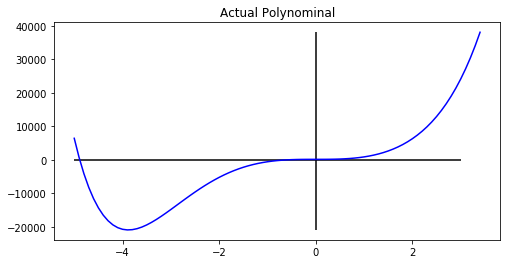

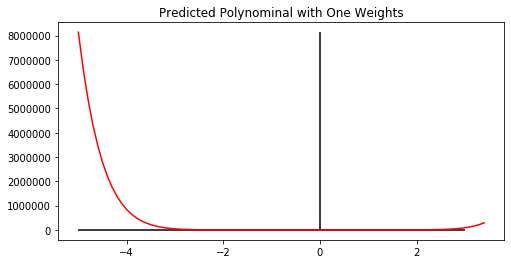

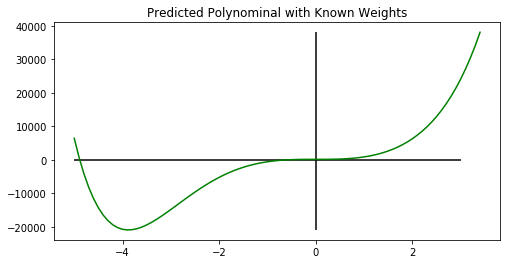

In [24]:
x_samples = torch.arange(-50, 35, 1) / 10.
z_values =  torch.squeeze(torch.tensor([func_actual(x) for x in x_samples]))

f = plt.figure(figsize=(8, 4))
plt.plot(x_samples, z_values, color='b')
plt.hlines(y=0, xmin=-5, xmax=3, color='black')
plt.vlines(x=0, ymin=torch.squeeze(z_values).min(), ymax=torch.squeeze(z_values).max(), color='black')
plt.title('Actual Polynominal')
plt.show()

one_weights = torch.ones([11])
z_hat_one_values = torch.tensor([func_predict(x, one_weights) for x in x_samples])

f = plt.figure(figsize=(8, 4))
plt.plot(x_samples, torch.squeeze(z_hat_one_values), color='r')
plt.hlines(y=0, xmin=-5, xmax=3, color='black')
plt.vlines(x=0, ymin=torch.squeeze(z_hat_one_values).min(), ymax=torch.squeeze(z_hat_one_values).max(), color='black')
plt.title('Predicted Polynominal with One Weights')
plt.show()

known_weights = torch.tensor([124, 4, 0.002, 721, 0, 0.14, 6.2, 0, 0, 0, 0])
z_hat_known_values = torch.tensor([func_predict(x, known_weights) for x in x_samples])

f = plt.figure(figsize=(8, 4))
plt.plot(x_samples, torch.squeeze(z_hat_known_values), color='g')
plt.hlines(y=0, xmin=-5, xmax=3, color='black')
plt.vlines(x=0, ymin=torch.squeeze(z_hat_known_values).min(), ymax=torch.squeeze(z_hat_known_values).max(), color='black')
plt.title('Predicted Polynominal with Known Weights')
plt.show()

#### As you can see, the first 2 curves are very different.
#### But if we input the right weights into our prediction function as we did in the 3rd curve, we get an exact fit.

### Wrap Everything as a Variable

We need to make sure that all every item in the computational graph for the loss function is a Variable.

This include the actual and predicted values, the samples of x we will use and the weights.

If we miss wrapping any item in the graph, we will get an error when we call loss.backward()

#### There are several ways to generate a tensor with caculates a gradiant on the forward pass. 

We will use the torch.autograd.Variable approach in most of this notebook.

In [25]:
ones = torch.ones([3])
ones_deprecated  = torch.ones([3], requires_grad=True)
ones_tensor = torch.tensor(torch.ones([3]), requires_grad=True)
ones_variable = Variable((torch.ones([3])), requires_grad=True)

print(f'requires_grad:\n ones: {ones.requires_grad} \
        \n ones_deprecated: {ones_deprecated.requires_grad} \
        \n ones_tensor: {ones_tensor.requires_grad} \
        \n ones_variable: {ones_variable.requires_grad}')

C:\Users\youci\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


requires_grad:
 ones: False         
 ones_deprecated: True         
 ones_tensor: True         
 ones_variable: True


In [26]:
x_samples = Variable(torch.arange(-500, 500, 1) / 10., requires_grad=True) # add more samples than we used in our plots
z_values =  Variable(torch.squeeze(torch.tensor([func_actual(x) for x in x_samples])), requires_grad=True)


one_weights = Variable(torch.ones([11]), requires_grad=True)
z_ones = func_predict(x_samples, one_weights)

known_weights = Variable(torch.tensor([124, 4, 0.002, 721, 0, 0.14, 6.2, 0, 0, 0, 0]), requires_grad=True)
z_known = func_predict(x_samples, known_weights)


### Now let's try to define a loss function to quantify the differences between the 2 results

We will use Mean Squared Error (MSE) for our loss function.  This will use an $L_2$ distance and therefore penalize outliers more.

The loss function doesn't have to be normalized or averaged, we just need some quantitative way to access the degree of inaccuracy.

In [27]:
def lossFunction(Y, Y_pred):
    return torch.mean((Y - Y_pred)) / len(Y)

In [28]:
ones_loss = lossFunction(z_values, z_ones)
known_loss = lossFunction(z_values, z_known)
print(f'Loss with 1 weights: {ones_loss:,}\nLoss with known weights: {known_loss}')

Loss with 1 weights: -8,880,541,138,944.0
Loss with known weights: 0.0


#### We get a very large loss with all the weights set to one, but our loss is Zero if we get the exact weights right

#### Let's make sure all inputs and our 2 loss functions are ready for backprop.

*Note: The loss function will only show the last gradient function which should be based on torch.sum*

In [29]:
print(f'x_samples: {x_samples.requires_grad}\n\
z_values: {z_values.requires_grad}\n\
one_weights: {one_weights.requires_grad}\n\
z_hat_one_values: {z_hat_one_values.requires_grad}\n\
known_weights: {known_weights.requires_grad}\n\
z_hat_known_values: {z_hat_known_values.requires_grad}\n\
ones_loss: {ones_loss.grad_fn}\n\
known_loss: {known_loss.grad_fn}'
     )

x_samples: True
z_values: True
one_weights: True
z_hat_one_values: False
known_weights: True
z_hat_known_values: False
ones_loss: <DivBackward0 object at 0x000001E4E7037548>
known_loss: <DivBackward0 object at 0x000001E4E7037548>


### BackProp

We will run the backward() on our 2 loss results.  Since the loss function produces a scalar value, we do not need to pass in the vector of ones.

### Loss for the Known Weights

In [30]:
known_loss.backward()
print(f'\nOne Weight Gradients:\n {known_weights.grad.data.numpy()}')


One Weight Gradients:
 [-1.00000028e-03  4.99998278e-05 -8.33334923e-01  1.24999955e-01
 -1.25000830e+03  3.12499817e+02 -2.23217400e+06  7.81250688e+05
 -4.34038170e+09  1.95312486e+09 -8.87816611e+12]


**All 11 gradient values are zero since the known weights produce an exact match**

### Loss for the Weights with all values = 1

In [31]:
ones_loss.backward()
print(f'\nOne Weight Gradients:\n {one_weights.grad.data.numpy()}')


One Weight Gradients:
 [-1.00000028e-03  4.99998278e-05 -8.33334923e-01  1.24999955e-01
 -1.25000830e+03  3.12499817e+02 -2.23217400e+06  7.81250688e+05
 -4.34038170e+09  1.95312486e+09 -8.87816611e+12]


**The 11 gradient values corrlate to the 11 weights**

$\dot {w_0} \approx 2e+19 \quad $ This shows the contribution of the *y-intercept* to the loss

$\dot {w_6} \approx 2e+29 \quad $ This shows the contribution of the $x^6$ cofficent's to the loss

In [32]:
def polyFeatures(value, degree=2):
    result = []
    for i in range(degree):
        result.append(value**i)
    return result
def ployFeaturePoints(start, end, stride, degree=2):
    result = []
    points = np.arange(start, end, stride)
    np.random.shuffle(points)
    for i in points:
        result.append(polyFeatures(i, degree))
    return torch.tensor(result)
def zeroGrad(t):
    if t.grad is not None:
        t.grad.data.zero_()
def zeroAllGrads():
    zeroGrad(x)
    zeroGrad(z)
    zeroGrad(z_pred)
    zeroGrad(training_weights)
def printWeights(W):
                    print(f'\nWeights: \n\
10:{W[10]:,.2f} \n\
 9:{W[9]:,.2f}  \n\
 8:{W[8]:,.2f}  \n\
 7:{W[7]:,.2f}  \n\
 6:{W[6]:,.2f}  \n\
 5:{W[5]:,.2f}  \n\
 4:{W[4]:,.2f}  \n\
 3:{W[3]:,.2f}  \n\
 2:{W[2]:,.2f}  \n\
 1:{W[1]:,.2f}  \n\
 0:{W[0]:,.2f}  ')

In [33]:
x = Variable(ployFeaturePoints(-50, 50, .1, 10), requires_grad=True)
z = Variable(torch.squeeze(torch.tensor([func_actual(i[1]) for i in x])), requires_grad=True)

criterion = lossFunction
lr = 1e-2

training_weights = Variable(torch.ones([11]), requires_grad=True)
printWeights(training_weights)


Weights: 
10:1.00 
 9:1.00  
 8:1.00  
 7:1.00  
 6:1.00  
 5:1.00  
 4:1.00  
 3:1.00  
 2:1.00  
 1:1.00  
 0:1.00  


In [34]:
for p in x[:,1]:
    z = func_actual(p)
    z_pred = func_predict(p, training_weights)
    print(z * z_pred)
    loss = torch.sigmoid(z - z_pred) * 500
    zeroGrad(x)
    zeroGrad(z)
    zeroGrad(z_pred)
    zeroGrad(training_weights)
    loss.backward()
    training_weights.data.add_(-lr, training_weights.grad.data)
    
printWeights(training_weights)    

tensor(7.4031e+22, grad_fn=<MulBackward0>)
tensor(3.7477e+22, grad_fn=<MulBackward0>)
tensor(5.1878e+24, grad_fn=<MulBackward0>)
tensor(3.9199e+24, grad_fn=<MulBackward0>)
tensor(8.4059e+24, grad_fn=<MulBackward0>)
tensor(4.4337e+20, grad_fn=<MulBackward0>)
tensor(9.8491e+17, grad_fn=<MulBackward0>)
tensor(5.6216e+24, grad_fn=<MulBackward0>)
tensor(1.6451e+12, grad_fn=<MulBackward0>)
tensor(2.7107e+24, grad_fn=<MulBackward0>)
tensor(2.1396e+09, grad_fn=<MulBackward0>)
tensor(6.8490e+26, grad_fn=<MulBackward0>)
tensor(2.2033e+25, grad_fn=<MulBackward0>)
tensor(2.2393e+18, grad_fn=<MulBackward0>)
tensor(9.4805e+12, grad_fn=<MulBackward0>)
tensor(1.4669e+25, grad_fn=<MulBackward0>)
tensor(3.4278e+24, grad_fn=<MulBackward0>)
tensor(6.9247e+22, grad_fn=<MulBackward0>)
tensor(2.7020e+27, grad_fn=<MulBackward0>)
tensor(2.9299e+27, grad_fn=<MulBackward0>)
tensor(-2.6848e+10, grad_fn=<MulBackward0>)
tensor(8.5822e+24, grad_fn=<MulBackward0>)
tensor(1.4725e+18, grad_fn=<MulBackward0>)
tensor(7.1

tensor(2.4139e+12, grad_fn=<MulBackward0>)
tensor(6.5175e+25, grad_fn=<MulBackward0>)
tensor(7.0829e+13, grad_fn=<MulBackward0>)
tensor(1.6159e+24, grad_fn=<MulBackward0>)
tensor(4.8734e+23, grad_fn=<MulBackward0>)
tensor(2.7484e+23, grad_fn=<MulBackward0>)
tensor(2.9966e+27, grad_fn=<MulBackward0>)
tensor(3.3020e+23, grad_fn=<MulBackward0>)
tensor(-1.4501e+09, grad_fn=<MulBackward0>)
tensor(3.1332e+22, grad_fn=<MulBackward0>)
tensor(7.3403e+23, grad_fn=<MulBackward0>)
tensor(1.6654e+24, grad_fn=<MulBackward0>)
tensor(2.9262e+24, grad_fn=<MulBackward0>)
tensor(1.6399e+22, grad_fn=<MulBackward0>)
tensor(1.0977e+22, grad_fn=<MulBackward0>)
tensor(2.5324e+22, grad_fn=<MulBackward0>)
tensor(1.3486e+27, grad_fn=<MulBackward0>)
tensor(1.2278e+08, grad_fn=<MulBackward0>)
tensor(1.9138e+25, grad_fn=<MulBackward0>)
tensor(2.4898e+26, grad_fn=<MulBackward0>)
tensor(7.6663e+26, grad_fn=<MulBackward0>)
tensor(6.5179e+17, grad_fn=<MulBackward0>)
tensor(2.1184e+26, grad_fn=<MulBackward0>)
tensor(2.6

tensor(1.4871e+26, grad_fn=<MulBackward0>)
tensor(8.5027e+27, grad_fn=<MulBackward0>)
tensor(1.4640e+26, grad_fn=<MulBackward0>)
tensor(4.5038e+27, grad_fn=<MulBackward0>)
tensor(3.8245e+25, grad_fn=<MulBackward0>)
tensor(2.5260e+20, grad_fn=<MulBackward0>)
tensor(4.8215e+24, grad_fn=<MulBackward0>)
tensor(1.0492e+17, grad_fn=<MulBackward0>)
tensor(5.9708e+25, grad_fn=<MulBackward0>)
tensor(-3592356.2500, grad_fn=<MulBackward0>)
tensor(7.0995e+10, grad_fn=<MulBackward0>)
tensor(1.9793e+22, grad_fn=<MulBackward0>)
tensor(4.9190e+17, grad_fn=<MulBackward0>)
tensor(9.6436e+14, grad_fn=<MulBackward0>)
tensor(1.3684e+26, grad_fn=<MulBackward0>)
tensor(3.0410e+12, grad_fn=<MulBackward0>)
tensor(8.7224e+22, grad_fn=<MulBackward0>)
tensor(7.7547e+25, grad_fn=<MulBackward0>)
tensor(9.4400e+21, grad_fn=<MulBackward0>)
tensor(3.7583e+11, grad_fn=<MulBackward0>)
tensor(9.9428e+26, grad_fn=<MulBackward0>)
tensor(1.1338e+23, grad_fn=<MulBackward0>)
tensor(6.5366e+23, grad_fn=<MulBackward0>)
tensor(1

In [35]:
z_pred = func_predict(x[:,1], training_weights)
loss = criterion(z, z_pred)
print(loss)
zeroAllGrads()
loss.backward()
# print(x.grad.data.numpy())
print(training_weights.grad.data.numpy())
training_weights.data.add_(-lr, training_weights.grad.data)
printWeights(training_weights)

TypeError: len() of a 0-d tensor

In [ ]:
z_pred = func_predict(x[:,1], training_weights)
loss = criterion(z, z_pred)
print(loss)
zeroAllGrads()
loss.backward()
# print(x.grad.data.numpy())
print(training_weights.grad.data.numpy())
training_weights.data.add_(-lr, training_weights.grad.data)
printWeights(training_weights)

In [ ]:
z_pred = func_predict(x[:,1], training_weights)
loss = criterion(z, z_pred)
print(loss)
zeroAllGrads()
loss.backward()
# print(x.grad.data.numpy())
print(training_weights.grad.data.numpy())
training_weights.data.add_(-lr, training_weights.grad.data)
printWeights(training_weights)

In [ ]:
z_pred = func_predict(x, training_weights)
loss = criterion(z, z_pred)
print(loss)
zeroAllGrads()
loss.backward()
# print(x.grad.data.numpy())
print(training_weights.grad.data.numpy())
training_weights.data.add_(-lr, training_weights.grad.data)
printWeights(training_weights)

In [ ]:
z_pred = func_predict(x, training_weights)
loss = criterion(z, z_pred)
print(loss)
zeroAllGrads()
loss.backward()
print(training_weights.grad.data.numpy())
training_weights.data.add_(-lr, training_weights.grad.data)
printWeights(training_weights)

In [ ]:
z_pred = func_predict(x, training_weights)
loss = criterion(z, z_pred)
print(loss)
zeroAllGrads()
loss.backward()
print(training_weights.grad.data.numpy())
training_weights.data.add_(-lr, training_weights.grad.data)
printWeights(training_weights)